# Representation Learning

In a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, we will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install torchinfo

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

%cd /content/drive/MyDrive/Unstructured_Data_Analytics/HW3/

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

/content/drive/MyDrive/Unstructured_Data_Analytics/HW3


**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

<ipython-input-5-35012220dad7>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


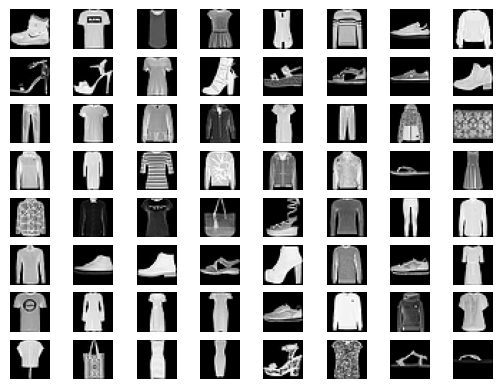

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a)** We select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [ ]:
import torch

# Filtering train data for pullovers (2) and shirts (6)
x_train = train_images[(train_labels == 2) | (train_labels == 6)]
y_train = train_labels[(train_labels == 2) | (train_labels == 6)]

# Remapping labels: 2 (pullovers) -> 0, 6 (shirts) -> 1
y_train = torch.where(y_train == 2, 0, 1)

# Filtering test data for pullovers (2) and shirts (6)
x_test = test_images[(test_labels == 2) | (test_labels == 6)]
y_test = test_labels[(test_labels == 2) | (test_labels == 6)]

# Remapping labels: 2 (pullovers) -> 0, 6 (shirts) -> 1
y_test = torch.where(y_test == 2, 0, 1)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [ ]:
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [ ]:
# Subsampling x_train and y_train using the random_sample indices
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

**(b)** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [ ]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt'))
convnet.eval()
print('[Summary of pre-trained convnet]')
print(summary(convnet, input_data=torch.zeros((1, 1, 28, 28))))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
print(summary(intermediate_layer_model, input_data=torch.zeros((1, 1, 28, 28))))

[Summary of pre-trained convnet]
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 26, 26]            60
├─ReLU: 1-2                              [1, 6, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 6, 13, 13]            --
├─Conv2d: 1-4                            [1, 16, 11, 11]           880
├─ReLU: 1-5                              [1, 16, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Flatten: 1-7                           [1, 400]                  --
├─Linear: 1-8                            [1, 120]                  48,120
├─ReLU: 1-9                              [1, 120]                  --
├─Linear: 1-10                           [1, 84]                   10,164
├─ReLU: 1-11                             [1, 84]                   --
├─Linear: 1-12                           [1

We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [ ]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, we visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.887489
[t-SNE] KL divergence after 1000 iterations: 1.063731
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.685081
[t-SNE] KL divergence after 1000 iterations: 0.991156


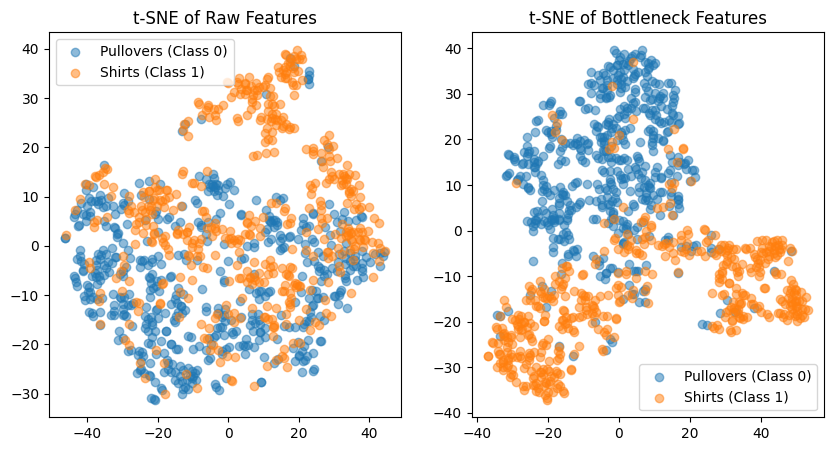

In [ ]:
x_train_small_np = x_train_small.numpy()
x_train_small_bottleneck_np = x_train_small_bottleneck_representation.cpu().numpy()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE for raw features
tsne_raw = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
tsne_raw_result = tsne_raw.fit_transform(x_train_small_np.reshape(len(x_train_small_np), -1))

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_raw_result[y_train_small == 0, 0], tsne_raw_result[y_train_small == 0, 1], label='Pullovers (Class 0)', alpha=0.5)
plt.scatter(tsne_raw_result[y_train_small == 1, 0], tsne_raw_result[y_train_small == 1, 1], label='Shirts (Class 1)', alpha=0.5)
plt.title('t-SNE of Raw Features')
plt.legend()

# t-SNE for bottleneck features
tsne_bottleneck = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
tsne_bottleneck_result = tsne_bottleneck.fit_transform(x_train_small_bottleneck_np)

# Plotting
plt.subplot(1, 2, 2)
plt.scatter(tsne_bottleneck_result[y_train_small == 0, 0], tsne_bottleneck_result[y_train_small == 0, 1], label='Pullovers (Class 0)', alpha=0.5)
plt.scatter(tsne_bottleneck_result[y_train_small == 1, 0], tsne_bottleneck_result[y_train_small == 1, 1], label='Shirts (Class 1)', alpha=0.5)
plt.title('t-SNE of Bottleneck Features')
plt.legend()
plt.show()


**(c)** We now evaluate on test data and compare several classifiers. Train a **5-NN** classifier (i.e., 5-nearest-neighbor classifier) with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 2 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features

Test each model on the **test dataset** and print the test dataset accuracy. Also, compute and print the test dataset accuracy of the **pre-trained convnet** (`convnet`). You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |                     | this cell stays empty|
| 5-NN             |                     |                      |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [ ]:
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

x_test = x_test.to('cpu')
y_test = y_test.to('cpu')

# Flatten the raw training and testing images for the 5-NN classifier
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Train 5-NN on raw features
knn_raw = KNeighborsClassifier(n_neighbors=5)

knn_raw.fit(x_train_flat, y_train)

# Train 5-NN on bottleneck features
knn_bottleneck = KNeighborsClassifier(n_neighbors=5)
knn_bottleneck.fit(x_train_bottleneck_representation.cpu(), y_train)

# Testing
y_pred_raw = knn_raw.predict(x_test_flat)
y_pred_bottleneck = knn_bottleneck.predict(x_test_bottleneck_representation.cpu())

# Calculate accuracy for raw features
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print(f"K-NN Raw Feature Test Accuracy: {accuracy_raw:.4f}")

# Calculate accuracy for bottleneck features
accuracy_bottleneck = accuracy_score(y_test, y_pred_bottleneck)
print(f"K-NN Bottleneck Feature Test Accuracy: {accuracy_bottleneck:.4f}")

#### 3rd Model Testing

# Forward pass through the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
convnet = convnet.to(device)

# Also move your input tensor to the device
x_test = x_test.to(device)
y_test = y_test.to(device)

outputs = convnet(x_test)

# Extract probabilities for class 2 (pullovers) and 6 (shirts)
# Given that class 2 is now 0 and class 6 is now 1 after remapping
probabilities = torch.stack([outputs[:, 2], outputs[:, 6]], dim=1)

# Determine the predicted classes from the probabilities
_, predicted = torch.max(probabilities, 1)

# Compare with the true labels
correct = (predicted == y_test).sum().item()

# Calculate the accuracy
convnet_accuracy = correct / len(y_test)

print(f"Pre-trained ConvNet Test Accuracy: {convnet_accuracy:.4f}")

K-NN Raw Feature Test Accuracy: 0.8560
K-NN Bottleneck Feature Test Accuracy: 0.8880
Pre-trained ConvNet Test Accuracy: 0.8910


Among the 3 models above, which model performed the best? Which model showed the lowest accuracy?

1.   Best Model - Pre Trained Convnet (Accuracy 89.1%)
2.   Worst Model - KNN Raw Features Model (Accuracy - 85.6%)

**(d)** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, we get 50 classifiers. Then we draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, we use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

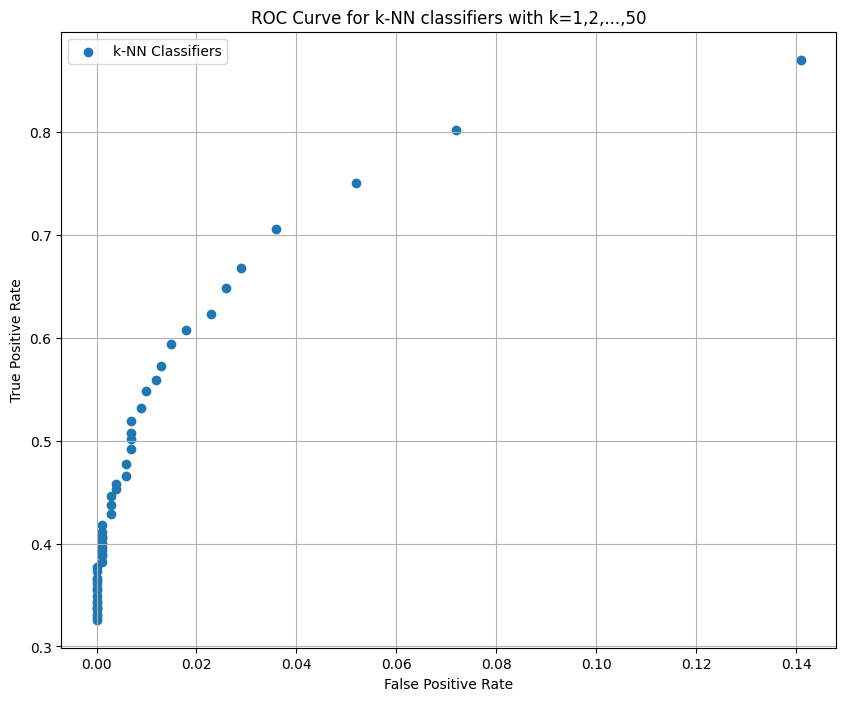

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Store TPR and FPR values
tprs = []
fprs = []


for k in range(1, 51):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_bottleneck_representation.cpu(), y_train)

    y_prob = knn.predict_proba(x_test_bottleneck_representation.cpu())[:, 1]  # Get probabilities for the positive class

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), y_prob, pos_label=1)  # 1 corresponds to class 6 (shirts)
    tprs.append(tpr[1])
    fprs.append(fpr[1])

# Plot the ROC scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(fprs, tprs, label='k-NN Classifiers')
plt.title('ROC Curve for k-NN classifiers with k=1,2,...,50')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()


Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Answer:**
If k = 2, then the TPR is 0.802 and fpr is 0.072 which is less than the threshold of 12.5% or 0.125

In [ ]:
max_tpr_for_k = max(tpr for fpr, tpr in zip(fprs, tprs) if fpr <= 0.125)

index = tprs.index(max_tpr_for_k)

print("Best value of K: ", index + 1)

Best value of K:  2
